# 多输入多输出通道：详细讲解

---

## 一、为什么需要"通道"？

### 从黑白到彩色

```
黑白图片：每个像素只有1个数字（亮度）
    → 1个通道

彩色图片：每个像素有3个数字（红、绿、蓝）
    → 3个通道

```

---

## 二、多输入通道：怎么处理彩色图片？

### 问题

```
之前：输入是1个矩阵（黑白图），用1个卷积核
现在：输入是3个矩阵（RGB），怎么办？
```

### 答案：每个通道配一个卷积核，结果加起来
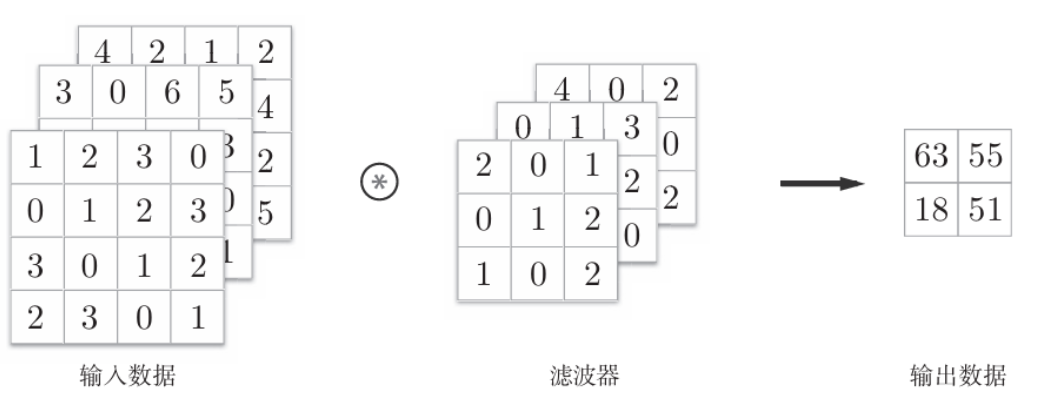

```
输入有3个通道（R、G、B）
卷积核也要有3个（分别对应R、G、B）

红色通道 × 红色的核 = 结果1
绿色通道 × 绿色的核 = 结果2
蓝色通道 × 蓝色的核 = 结果3

最终输出 = 结果1 + 结果2 + 结果3
```

---

## 三、多输出通道：为什么需要？

### 问题

```
如果每次卷积只输出1个通道
那只能检测1种特征（比如只能检测竖线）

但我想同时检测很多种特征：
    竖线、横线、斜线、角落、纹理...
    
怎么办？
```

### 答案：用多个卷积核，每个输出一个通道

```
卷积核1（检测竖线）→ 输出通道1
卷积核2（检测横线）→ 输出通道2  
卷积核3（检测斜线）→ 输出通道3
...
卷积核16（检测某种纹理）→ 输出通道16

16个卷积核 → 16个输出通道
```
---

## 四、通道数在代码里怎么体现？

### 你已经会的

```python
nn.Conv2d(in_channels, out_channels, kernel_size)
```

**现在你知道这些参数的真正含义了：**

```python
nn.Conv2d(3, 16, kernel_size=3)
#         ^   ^
#         |   输出16个通道 = 用16个不同的卷积核
#         |                  每个检测一种特征
#         |
#         输入3个通道 = RGB彩色图片
#                      每个卷积核要处理3个通道
```

### 多层堆叠时，通道数怎么接

```python
net = nn.Sequential(
    nn.Conv2d(3, 16, kernel_size=3, padding=1),
    #         ^  ^^
    #     3进 16出 → 彩色图片进来，提取16种特征
    nn.ReLU(),
    
    nn.Conv2d(16, 32, kernel_size=3, padding=1),
    #         ^^  ^^
    #         16进 32出 → 上一层出16，这一层吃16
    #   输出32种更复杂的特征
    nn.ReLU(),
    
    nn.Conv2d(32, 64, kernel_size=3, padding=1),
    #         ^^  ^^
    #     32进 64出 → 上一层出32，这一层吃32
      输出64种更更复杂的特征
)
```

**规律：前一层的out_channels = 后一层的in_channels**

```
这和nn.Linear一模一样！

nn.Linear(20, 256)     → 20进256出
nn.Linear(256, 10)     → 256进10出
         前一层的出 = 后一层的进

nn.Conv2d(3, 16, ...)  → 3通道进16通道出
nn.Conv2d(16, 32, ...) → 16通道进32通道出
         前一层的出 = 后一层的进
```

---

### 为什么通道数越来越大？（3→16→32→64）

```
第1层：基础特征很少（线条、边缘就那几种）→ 16个够了
第2层：组合多一些 → 32个
第3层：更多组合 → 64个
...

越往上，特征越复杂，种类越多
所以通道数越来越大
```

---

## 单独谈1×1卷积与通道变化

## 问题：凭什么3通道能变2通道？

```
输入：3个通道
    通道R = 红色信息
    通道G = 绿色信息  
    通道B = 蓝色信息

输出通道1 = 0.5×R + 0.3×G + 0.2×B    ← 第1组权重
输出通道2 = 0.1×R + 0.6×G + 0.3×B    ← 第2组权重
```

**你设了几组权重，就有几个输出通道！**

```
想要2个输出？ → 设2组权重 → 2个输出通道
想要16个输出？ → 设16组权重 → 16个输出通道
想要100个输出？ → 设100组权重 → 100个输出通道
```
---

## 也可以不减少输出通道数

```python
# 3通道 → 2通道（变少）
nn.Conv2d(3, 2, kernel_size=3)     # 2组权重

# 3通道 → 3通道（不变）
nn.Conv2d(3, 3, kernel_size=3)     # 3组权重

# 3通道 → 16通道（变多！）
nn.Conv2d(3, 16, kernel_size=3)    # 16组权重

# 3通道 → 100通道（变更多！）
nn.Conv2d(3, 100, kernel_size=3)   # 100组权重
```

**输出通道数完全是你自己决定的！想多少就多少！**

---

## 那会不会丢信息？或者为什么还要让通道变少？

```
场景：上一层输出了256个通道
      但其中很多通道的信息是重复的、冗余的
      你只需要保留64个最重要的组合就够了

256通道 → 64通道
虽然丢了一些，但丢的是"冗余的"
保留的是"有用的组合"
```

---

## 那1×1卷积到底在干什么？

### 普通卷积（3×3）做两件事

```
1. 看周围的像素（空间信息）   ← 3×3窗口
2. 混合不同通道（通道融合）   ← 加权求和
```

### 1×1卷积只做一件事

```
1. 看周围的像素？不看！只看自己这一个点
2. 混合不同通道 ← 只做这个！
```
---

### 用途：调整通道数

```
场景：上一层输出256通道，但下一层只需要64通道

方法1：直接连（不行！通道数对不上）
    nn.Conv2d(256, 64, kernel_size=3)  → 也能改通道数
    但同时还改了空间信息，而且参数多

方法2：先用1×1卷积调整通道数
    nn.Conv2d(256, 64, kernel_size=1)  → 只改通道数
    不动空间信息，参数很少！
```

### 参数量对比

```
256通道→64通道：

用3×3卷积：256 × 64 × 3 × 3 = 147,456个参数
用1×1卷积：256 × 64 × 1 × 1 = 16,384个参数

1×1卷积参数少了9倍！
便宜地调整通道数
参数少，计算快
ResNet等网络里大量使用
```

---

## 实际中通道数是怎么变的？
```
输入         → 3通道（RGB）
第1层        → 16通道        变多！扩展信息
第2层        → 32通道        变多！
第3层        → 64通道        变多！
...
某些层       → 通道变少       减少冗余（1×1卷积常干这个）
...
最后         → 类别数（比如10）最终压缩成分类结果
```


### 需要记的

```
nn.Conv2d(输入通道, 输出通道, kernel_size)
         前一层决定  你自己设   窗口大小

通道数随便设！3→2、3→16、256→64都行
前一层的输出通道 = 后一层的输入通道（对上就行）
```
---

### 代码

```python
# 前一层的out = 后一层的in
nn.Conv2d(3, 16, kernel_size=3, padding=1)     # RGB进，16种特征出
nn.Conv2d(16, 32, kernel_size=3, padding=1)    # 16进32出
nn.Conv2d(32, 64, kernel_size=3, padding=1)    # 32进64出

# 1×1卷积：调整通道数
nn.Conv2d(256, 64, kernel_size=1)  # 256通道减少为64通道
```
